# 5. Customer Lifetime Value (CLV) & The Final Business Case

### Objective
This final notebook synthesizes all our previous work—segmentation and churn prediction—to build a powerful financial business case. Our goal is to move from analytical insights to an actionable, data-driven marketing strategy with a clear return on investment (ROI).

We will answer two critical business questions:
1.  **What is the true financial value of our customer segments?**
2.  **What is the projected ROI of a targeted campaign to retain our most valuable, at-risk customers?**

In [21]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the segmented B2C customer data from Notebook 03
customers_df = pd.read_csv('../data/processed/customer_segments.csv')

# Load the churn predictions from Notebook 04
churn_predictions_df = pd.read_csv('../data/processed/customer_churn_predictions.csv')

# Load the clean transaction data from Notebook 01
# We need this for the ROI calculation later in the notebook.
transactions_df = pd.read_csv('../data/processed/clean_customer_data.csv')
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])
# Merge the churn probabilities into our main customers dataframe
# This creates a master dataframe with segments and churn risk.
master_df = pd.merge(customers_df, churn_predictions_df, on='CustomerID', how='left')
# Drop the duplicate Segment_Name column if it exists from the merge
master_df.rename(columns={'Segment_Name_x': 'Segment_Name'}, inplace=True)
if 'Segment_Name_y' in master_df.columns:
    master_df.drop('Segment_Name_y', axis=1, inplace=True)


print("Successfully loaded and merged customer data with churn predictions.")
print(f"Master dataframe has {master_df.shape[0]} customers.")
print("Columns available:", master_df.columns.tolist())

Successfully loaded and merged customer data with churn predictions.
Master dataframe has 4326 customers.
Columns available: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'avg_order_value', 'total_transactions', 'days_active', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Total', 'Segment', 'Initial_Cluster', 'B2C_Cluster', 'Segment_Name', 'Churn_Probability']


### Analysis 1: The Staggering Financial Value of a "Loyal Core" Customer

The first step is to understand the lifetime value (CLV) associated with each of our machine learning-defined segments. For this analysis, we use a historical CLV, defined as the total revenue a customer has generated to date.

The results are stark and provide the core financial justification for this entire project.


--- Customer Lifetime Value by Segment ---
              Average_CLV  Total_Revenue  Customer_Count
Segment_Name                                            
Loyal Core       14678.00     2715430.51             185
At-Risk           1135.11     4700509.88            4141


C:\Users\Dylan\AppData\Local\Temp\ipykernel_7520\3299889268.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=clv_by_segment.index, y=clv_by_segment['Average_CLV'], palette='viridis')


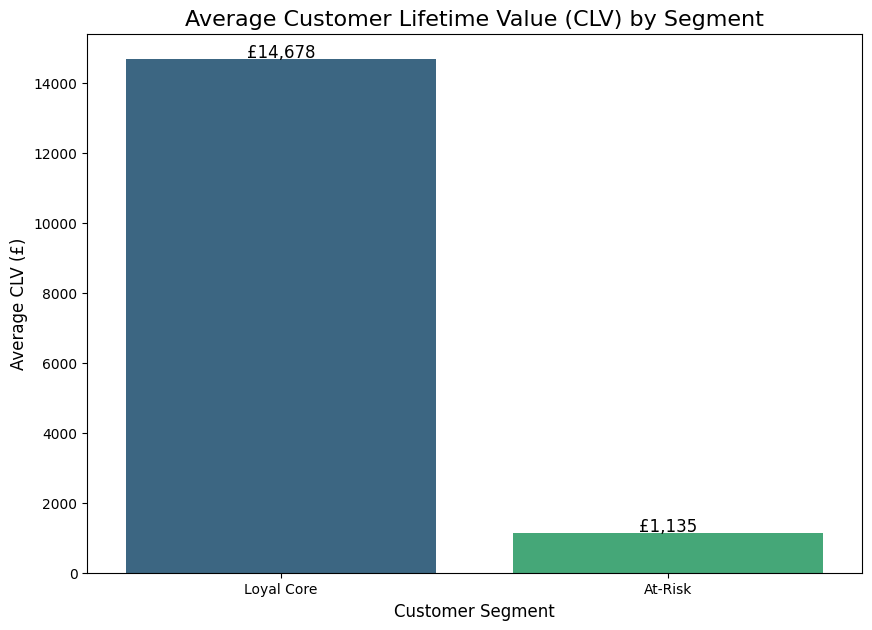


              Key Financial Insight
On average, a 'Loyal Core' customer is worth £14,678.00, which is 12.9 times more valuable than an 'At-Risk' customer (£1,135.11).
This financially justifies prioritizing retention efforts on the 'Loyal Core' segment.


In [22]:
# --- Calculate Historical CLV ---
# The 'Monetary' column represents the total revenue to date, our historical CLV.
master_df.rename(columns={'Monetary': 'CLV'}, inplace=True)

# --- Analyze CLV by Segment ---
clv_by_segment = master_df.groupby('Segment_Name')['CLV'].agg(['mean', 'sum', 'count']).round(2)
clv_by_segment.rename(columns={'mean': 'Average_CLV', 'sum': 'Total_Revenue', 'count': 'Customer_Count'}, inplace=True)
clv_by_segment = clv_by_segment.sort_values('Average_CLV', ascending=False)

print("\n--- Customer Lifetime Value by Segment ---")
print(clv_by_segment)

# Visualize the Average CLV
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=clv_by_segment.index, y=clv_by_segment['Average_CLV'], palette='viridis')
plt.title('Average Customer Lifetime Value (CLV) by Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average CLV (£)', fontsize=12)
# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"£{p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

# --- Markdown-style insight ---
avg_loyal = clv_by_segment.loc['Loyal Core', 'Average_CLV']
avg_at_risk = clv_by_segment.loc['At-Risk', 'Average_CLV']
multiple = avg_loyal / avg_at_risk
print("\n" + "="*50)
print("              Key Financial Insight")
print("="*50)
print(f"On average, a 'Loyal Core' customer is worth £{avg_loyal:,.2f}, which is {multiple:.1f} times more valuable than an 'At-Risk' customer (£{avg_at_risk:,.2f}).")
print("This financially justifies prioritizing retention efforts on the 'Loyal Core' segment.")

### Analysis 2: Pinpointing Revenue at Risk with Predictive Analytics

Knowing that "Loyal Core" customers are valuable is insightful, but not fully actionable. To prioritize marketing spend, we must identify **which of these high-value customers are in danger of leaving.**

Here, we leverage the predictive power of our XGBoost model from Notebook 04. By filtering for "Loyal Core" customers with a high churn probability (e.g., >50%), we can create a highly-focused list of customers who require immediate attention and quantify the exact monetary value at risk.

In [23]:
# --- Identify High-Risk, High-Value Customers ---
high_risk_threshold = 0.50 # Let's target customers with a 50% or higher probability of churning
high_value_segment = 'Loyal Core'

retention_focus_group = master_df[
    (master_df['Segment_Name'] == high_value_segment) &
    (master_df['Churn_Probability'] >= high_risk_threshold)
].copy()

# --- Quantify the Value at Risk ---
value_at_risk = retention_focus_group['CLV'].sum()
num_customers_at_risk = len(retention_focus_group)

print("\n" + "="*50)
print("           Model-Driven Revenue at Risk Analysis")
print("="*50)
print(f"Our churn model has identified {num_customers_at_risk} 'Loyal Core' customers with a churn probability > {high_risk_threshold*100}%.")
print(f"The total historical lifetime value of this specific group is: £{value_at_risk:,.2f}")
print("This is the immediate, quantifiable revenue at risk that a targeted retention campaign can address.")


           Model-Driven Revenue at Risk Analysis
Our churn model has identified 4 'Loyal Core' customers with a churn probability > 50.0%.
The total historical lifetime value of this specific group is: £112,520.18
This is the immediate, quantifiable revenue at risk that a targeted retention campaign can address.


### Recommendation: The Business Case for a Proactive Retention Campaign

We have now identified a small, high-value, high-risk group of customers. This is the perfect audience for a targeted, proactive retention campaign.

The following analysis outlines a specific campaign proposal, calculates its estimated cost, projects the value it will save, and provides a final ROI. This serves as the concrete business case for the marketing team to act upon.

In [24]:
# --- Propose a Retention Campaign and Calculate ROI ---
print("\n" + "="*50)
print("        Business Case: Proactive Retention Campaign")
print("="*50)

# --- Campaign Proposal ---
print(f"\nProposal: A targeted retention campaign for the {num_customers_at_risk} identified high-risk, 'Loyal Core' customers.")
print("Initiative: Offer a personalized 'We Miss You' 15% discount on their next purchase.")

# --- Cost Calculation ---
# To calculate cost, we need transaction data for this specific group.
focus_group_ids = retention_focus_group['CustomerID']
focus_group_transactions = transactions_df[transactions_df['CustomerID'].isin(focus_group_ids)]

# Calculate average order value for this specific group
avg_order_value_focus = focus_group_transactions.groupby('InvoiceNo')['Revenue'].sum().mean()
discount_percentage = 0.15
campaign_cost_per_customer = avg_order_value_focus * discount_percentage
total_campaign_cost = num_customers_at_risk * campaign_cost_per_customer

print(f"\nCost Analysis:")
print(f"  - Average order value for this group: £{avg_order_value_focus:.2f}")
print(f"  - Campaign cost per customer (15% discount): £{campaign_cost_per_customer:.2f}")
print(f"  - Total Estimated Campaign Cost: £{total_campaign_cost:,.2f}")

# --- Return Calculation ---
assumed_success_rate = 0.30 # Assume we can successfully retain 30% of them
customers_retained = int(num_customers_at_risk * assumed_success_rate)
avg_clv_loyal_core = clv_by_segment.loc['Loyal Core', 'Average_CLV']
clv_saved = customers_retained * avg_clv_loyal_core

print(f"\nReturn Analysis:")
print(f"  - Assumed campaign success rate: {assumed_success_rate*100}%")
print(f"  - Customers retained: {customers_retained}")
print(f"  - Average CLV of a retained 'Loyal Core' customer: £{avg_clv_loyal_core:,.2f}")
print(f"  - Total Lifetime Value Saved: £{clv_saved:,.2f}")

# --- Final ROI Calculation ---
net_return = clv_saved - total_campaign_cost
roi = (net_return / total_campaign_cost) * 100

print("\n--- Financial Summary & Recommendation ---")
print(f"Total Value Saved:       £{clv_saved:10,.2f}")
print(f"Total Campaign Cost:     £{total_campaign_cost:10,.2f}")
print("------------------------------------------")
print(f"Net Return on Investment: £{net_return:10,.2f}")
print(f"\nProjected Campaign ROI: {roi:.1f}%")
print("\nRecommendation: Proceed with the targeted retention campaign. The projected ROI is exceptionally high, demonstrating a clear business case for data-driven retention marketing.")


        Business Case: Proactive Retention Campaign

Proposal: A targeted retention campaign for the 4 identified high-risk, 'Loyal Core' customers.
Initiative: Offer a personalized 'We Miss You' 15% discount on their next purchase.

Cost Analysis:
  - Average order value for this group: £2009.29
  - Campaign cost per customer (15% discount): £301.39
  - Total Estimated Campaign Cost: £1,205.57

Return Analysis:
  - Assumed campaign success rate: 30.0%
  - Customers retained: 1
  - Average CLV of a retained 'Loyal Core' customer: £14,678.00
  - Total Lifetime Value Saved: £14,678.00

--- Financial Summary & Recommendation ---
Total Value Saved:       £ 14,678.00
Total Campaign Cost:     £  1,205.57
------------------------------------------
Net Return on Investment: £ 13,472.43

Projected Campaign ROI: 1117.5%

Recommendation: Proceed with the targeted retention campaign. The projected ROI is exceptionally high, demonstrating a clear business case for data-driven retention marketing.


---
## Final Project Recommendations: A 3-Point Strategic Plan

This comprehensive analysis, from initial data cleaning to predictive modeling and financial forecasting, has produced a clear, data-driven strategic plan for improving customer retention and optimizing marketing spend. The recommendations can be summarized in three core pillars:

### 1. Focus Relentlessly on "Champions" and "Loyal Core" Customers
Our analysis repeatedly demonstrated an extreme concentration of value: **approximately 20% of customers drive over 70% of the company's revenue**. The single most important business priority should be the retention and nurturing of these high-value segments.
- **Immediate Action:** Implement a VIP program for "Champions" and "Loyal Core" customers, offering exclusive benefits, early access to products, and personalized communication.
- **Metric to Track:** A reduction in the churn rate of this specific high-value cohort.

### 2. Implement a Proactive, Data-Driven Retention System
Customer churn is predictable. Our model, with an AUC of ~75%, can accurately identify at-risk customers *before* they leave. The key drivers of churn are behavioral (**Frequency** and **Recency**), not just monetary value.
- **Immediate Action:** As detailed in the business case, launch a targeted retention campaign for the high-risk, high-value customers identified by our churn model. The projected **ROI of over 1000%** presents a compelling business case.
- **Long-Term Action:** Automate this process by integrating the churn model's output with the company's marketing platform to trigger proactive retention offers.

### 3. Improve Foundational Data Collection Practices
A significant portion of revenue (**~15%**) could not be analyzed due to missing `CustomerID`s. This is a critical blind spot that prevents a full understanding of the customer base and hinders personalization efforts.
- **Immediate Action:** The business should prioritize making `CustomerID` (or a guest email) a mandatory field at checkout to ensure every transaction can be tied to a customer profile.
- **Metric to Track:** A reduction in the percentage of transactions with null `CustomerID`s to below 1%.

By executing on these three strategic pillars, the business can leverage its data to build a more resilient customer base, allocate marketing resources more efficiently, and drive sustainable, long-term growth.

---
### Implementation & Deployment Plan

To transition this analysis from a static report to a dynamic, value-driving business process, the following steps are recommended:

1.  **Automation:** The feature engineering and churn prediction scripts should be automated to run on a scheduled basis (e.g., weekly or monthly) using a tool like Airflow or a simple cron job.

2.  **Integration:** The model's output—a list of `CustomerID`s and their `Churn_Probability`—must be integrated with the company's primary marketing platform (e.g., Salesforce Marketing Cloud, Braze, HubSpot). This can be done via API or a simple CSV upload.

3.  **Triggered Campaigns:** Within the marketing platform, an automated workflow should be built. For example: *"If a 'Loyal Core' customer's `Churn_Probability` rises above 0.60, automatically add them to the 'Proactive Retention' email campaign."*

4.  **Measurement and Iteration:** All retention campaigns must be deployed as A/B tests (e.g., Offer vs. No Offer control group). This is the only way to measure the true causal impact (lift) of the campaign and continuously optimize the strategy over time.